# Neural Net Using Pytorch
This model uses Pytorch to create a multi-layered neural network with a sigmoid activation function.

## Neural Net Definition
This is a simple neural network architecture with two inputs, a single hidden
layer with four nodes, and two outputs. Its goal is to learn the output of a
boolean operator based on the two inputs. Additionally, it utilizes SGD as an
optimizer for the learning process.

In [7]:
from torch import nn, optim, Tensor, float32

#
# Neural network for learning boolean operations
#
class NeuralNet(nn.Module):
    def __init__(self) -> None:
        """Init NeuralNet with 2 inputs, 1 hidden layer with 4 nodes, and 2 outputs"""
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 4, dtype=float32),
            nn.Sigmoid(),
            nn.Linear(4, 2, dtype=float32)
        )

    def forward(self, x) -> Tensor:
        """Propagate values through layer in network"""
        logits = self.layers(x)
        probs = nn.Softmax(-1)(logits)
        return probs

In [8]:
_model = NeuralNet()
print(_model)

NeuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


### Util Function for Boolean Operations Dataset
The `get_pair()` function takes an operator from the `operator` library as
input, and produces two tensors containing the inputs for the NN and the correct
outputs respectively.

In [9]:
import numpy as np
import operator

def get_pair(operator) -> tuple[Tensor, Tensor]:
    """Generate a set of inputs and correct output for model"""
    values = np.random.choice([1, 0], 2)            # Two random inputs
    answer = [int(operator(values[0], values[1]))]  # Get correct output
    answer += [int(not answer[0])]
    return Tensor(values).type(float32), Tensor(answer).type(float32)

### Util Functions for Training/Validating

#### Training
There are several different ways to train a model. This method uses batching to
combine multiple inputs in a way that allows them to be computed separately
within the model. While batching the data decreases the processing speed over
one iteration, it allows the model to increase the amount of data processed over
this step. By adjusting the batch size according to the model/hardware, the
total amount of data processed over the same period of time can increase.

During the training step, increasing the batch size for the same amount of data
can be detrimental to model performance without any additional changes. To
mitigate this, the learning rate can be increased to compensate for the fact
that less steps are being performed over the entire dataset. Additionally,
another method increases the batch size instead of iteratively decreasing the
learning rate. This implementation uses the former for simplicity's sake.

Here, after the model has run over each batch, the average loss over the batches
is returned as an indicator of how well the model is learning. Subsequent
training steps can then be run over multiple epochs to get an idea of how well
the model is learning over time. Typically, one epoch involves one training step
over the entire dataset. However, since there  are only four possible states for
the task this model is learning, the amount of batches and epochs are chosen at
random.

In [10]:
import torch

loss_fn = nn.MSELoss()
optimizer = optim.SGD(_model.parameters(), lr=0.018)

def train(operator, batches, batch_size=5, model=_model) -> float:
    loss_hist = []
    for batch in range(batches):
        pairs, labels = [], []
        for _ in range(batch_size):
            pair, label = get_pair(operator)
            pairs.append(pair)
            labels.append(label)

        data = torch.stack(pairs)
        true = torch.stack(labels)

        pred: Tensor = model(data)
        loss: Tensor = loss_fn(pred, true)
        loss_hist.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.array(loss_hist).mean()


#### Validation
Since there are four possible inputs and outputs, this validation step will
generate all four and use the model to predict over them. More complex
classification models use metrics such as Receiver Operating Characteristics
(ROCs) to calculate different rates of true/false positives and negatives.

Here, the inputs, predictions, and true outputs are returned to allow the caller
to perform metric calculation.

In [11]:
def validate(operator, model=_model) -> dict:
    """Validate the test neural network"""
    # Generate validation set
    values: list[list[int]] = []
    for val_1 in range(2):
        for val_2 in range(2):
            values.append([val_1, val_2])

    predictions = []
    true_labels = []

    # Run network on validation set
    for it, inputs in enumerate(values):
        with torch.no_grad():
            preds = model(Tensor(inputs)).tolist()
        label = [int(operator(inputs[0], inputs[1]))]
        label += [int(not label[0])]

        predictions.append(round(preds[0]))
        predictions.append(round(preds[1]))
        true_labels.append(label[0])
        true_labels.append(label[1])

    return {
        "inputs": inputs,
        "preds": predictions,
        "labels": true_labels
    }

### Train and Evaluate Model
Using DVC (Data Version Control), live plotting of the loss during training can
be performed.  Additionally, a confusion matrix is generated for showing how
often the model produces incorrect outputs and can be viewed by either using DVC
in the command line or in the VS Code extension.

# DVC Report

metrics.json

|   train.avg_loss |   step |
|------------------|--------|
|        0.0376581 |     99 |

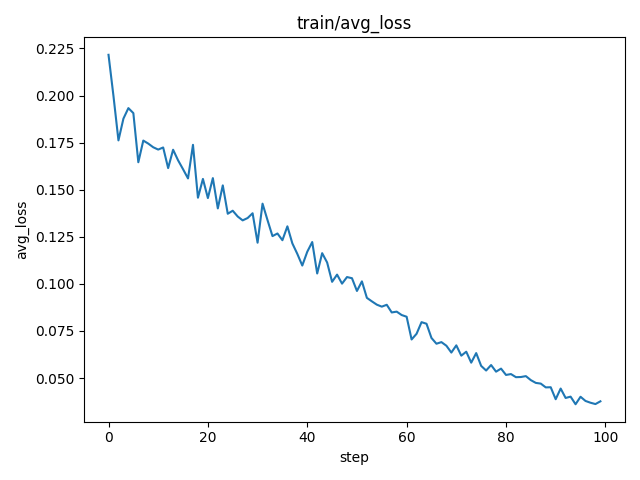



In [12]:
from dvclive import Live
op = operator.and_
epochs = 100
with Live(report='notebook', save_dvc_exp=False) as live:
    for epoch in range(epochs):
        avg_loss = train(op, 100)
        live.log_metric('train/avg_loss', avg_loss)
        metrics = validate(op)
        live.log_sklearn_plot('confusion_matrix', metrics['labels'], metrics['preds'], 'valid/metrics')
        live.next_step()